In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pymc as pm
# import pymc_bart as pmb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.inspection import permutation_importance

In [3]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [4]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['LUMO']
X = data.loc[:, ['Molecular Weight', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'NO Count',
         'Heteroatoms', 'H Count',  'Triple Bonds']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=42)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))
print('Train Mean Absolute Error:', abs(grid_cv.predict(X_train) - y_train), 'degrees.')
print("Train R2: ", r2_score(y_train, grid_cv.predict(X_train)))
print("Test R2: ", r2_score(y_test, grid_cv.predict(X_test)))
# rmse = mse**.5
print("Train MSE: ", mean_squared_error(y_train, grid_cv.predict(X_train)))
print("Test MSE: ", mean_squared_error(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.7888888888888891
Train AUC ROC Score for GS:  0.942063492063492
Test AUC ROC Score for GS:  0.7777777777777778
Train Mean Absolute Error: 7     0.444572
6     0.838543
2     0.531271
37    0.589835
39    0.499314
35    0.068527
44    0.060089
27    0.383348
12    0.168643
31    1.505349
21    0.037345
5     0.745493
13    0.084673
19    0.317212
17    0.551214
14    0.158547
4     0.707489
45    0.556801
1     0.256973
26    0.064932
32    0.011250
24    0.138948
22    0.142981
11    0.198596
16    0.803121
43    0.022990
46    0.323211
8     0.100693
38    0.005389
29    0.629898
25    0.199281
28    0.024257
0     0.570930
15    1.464312
36    0.422065
9     0.348109
Name: LUMO, dtype: float64 degrees.
Train R2:  0.94764142616884
Test R2:  0.5570752724383461
Train MSE:  0.2819675449278918
Test MSE:  2.5216111285928227


Mean Absolute Error: 1.2 eV.
R2:  0.5570752724383461
MSE:  2.5216111285928227
RMSE:  1.5879581633635134


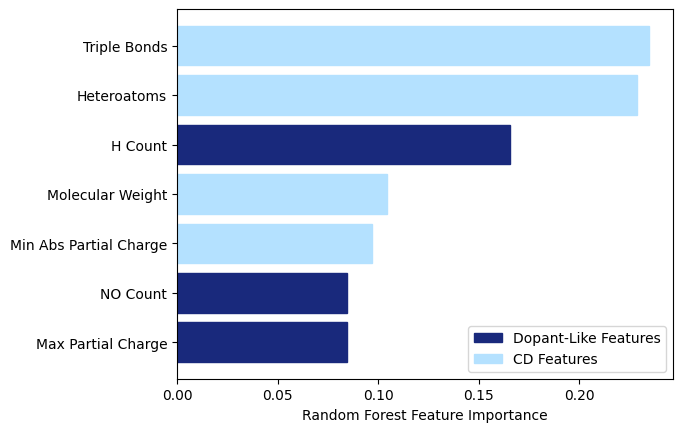

In [6]:
import matplotlib.patches as mpatches

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
bars = plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
bars[0].set_color('#19297C')
bars[1].set_color('#19297C')
bars[2].set_color('#B4E1FF')
bars[3].set_color('#B4E1FF')
bars[4].set_color('#19297C')
bars[5].set_color('#B4E1FF')
bars[6].set_color('#B4E1FF')
plt.xlabel("Random Forest Feature Importance")

both = mpatches.Patch(color='#19297C', label='Dopant-Like Features')
hv = mpatches.Patch(color='#B4E1FF', label='CD Features')
plt.legend(handles=[both, hv])

plt.rc('font', **font)


from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'eV.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [7]:
count = 0

for i in data.loc[:, 'smiles']:
    if i.__contains__('no'):
        count += 1

print(count)

0


In [8]:
data = pd.read_csv('Dopant_Data.csv')

# get data
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['HOMO']
X = data.loc[:, ['Molecular Weight',
         'Min Abs Partial Charge',
        'Ring Count', 'H Count', 'Double Bonds', 'Aliphatic Rings']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

Mean Absolute Error: 0.72 eV.
R2:  0.3842215048563854
MSE:  1.1450226940553492
RMSE:  1.0700573321347548


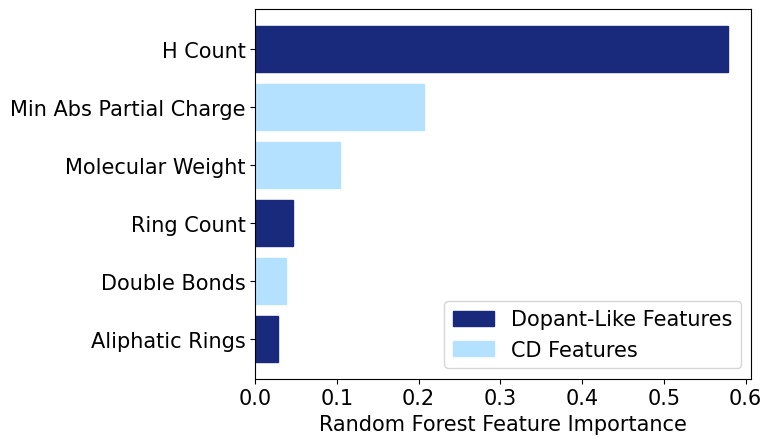

In [10]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

rfr = RandomForestRegressor(random_state=42, max_depth=3, min_samples_leaf=1, min_samples_split=10)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()
bars = plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
bars[0].set_color('#19297C')
bars[1].set_color('#B4E1FF')
bars[2].set_color('#19297C')
bars[3].set_color('#B4E1FF')
bars[4].set_color('#B4E1FF')
bars[5].set_color('#19297C')
plt.xlabel("Random Forest Feature Importance")

both = mpatches.Patch(color='#19297C', label='Dopant-Like Features')
hv = mpatches.Patch(color='#B4E1FF', label='CD Features')
plt.legend(handles=[both, hv])

plt.rc('font', **font)


from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'eV.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)